## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy import special

from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

## Specific library to import

In [3]:
import empymod
from geoana.em.tdem import ElectricDipoleWholeSpace
from geoana.utils import ndgrid
# from geoana_rev.em.tdem import ElectricDipoleWholeSpace as ElectricDipoleWholeSpaceRev
# from geoana_rev.utils import ndgrid as ndgridRev


## Forward modelling test: Comparison between empymod, geoana and analytic solution

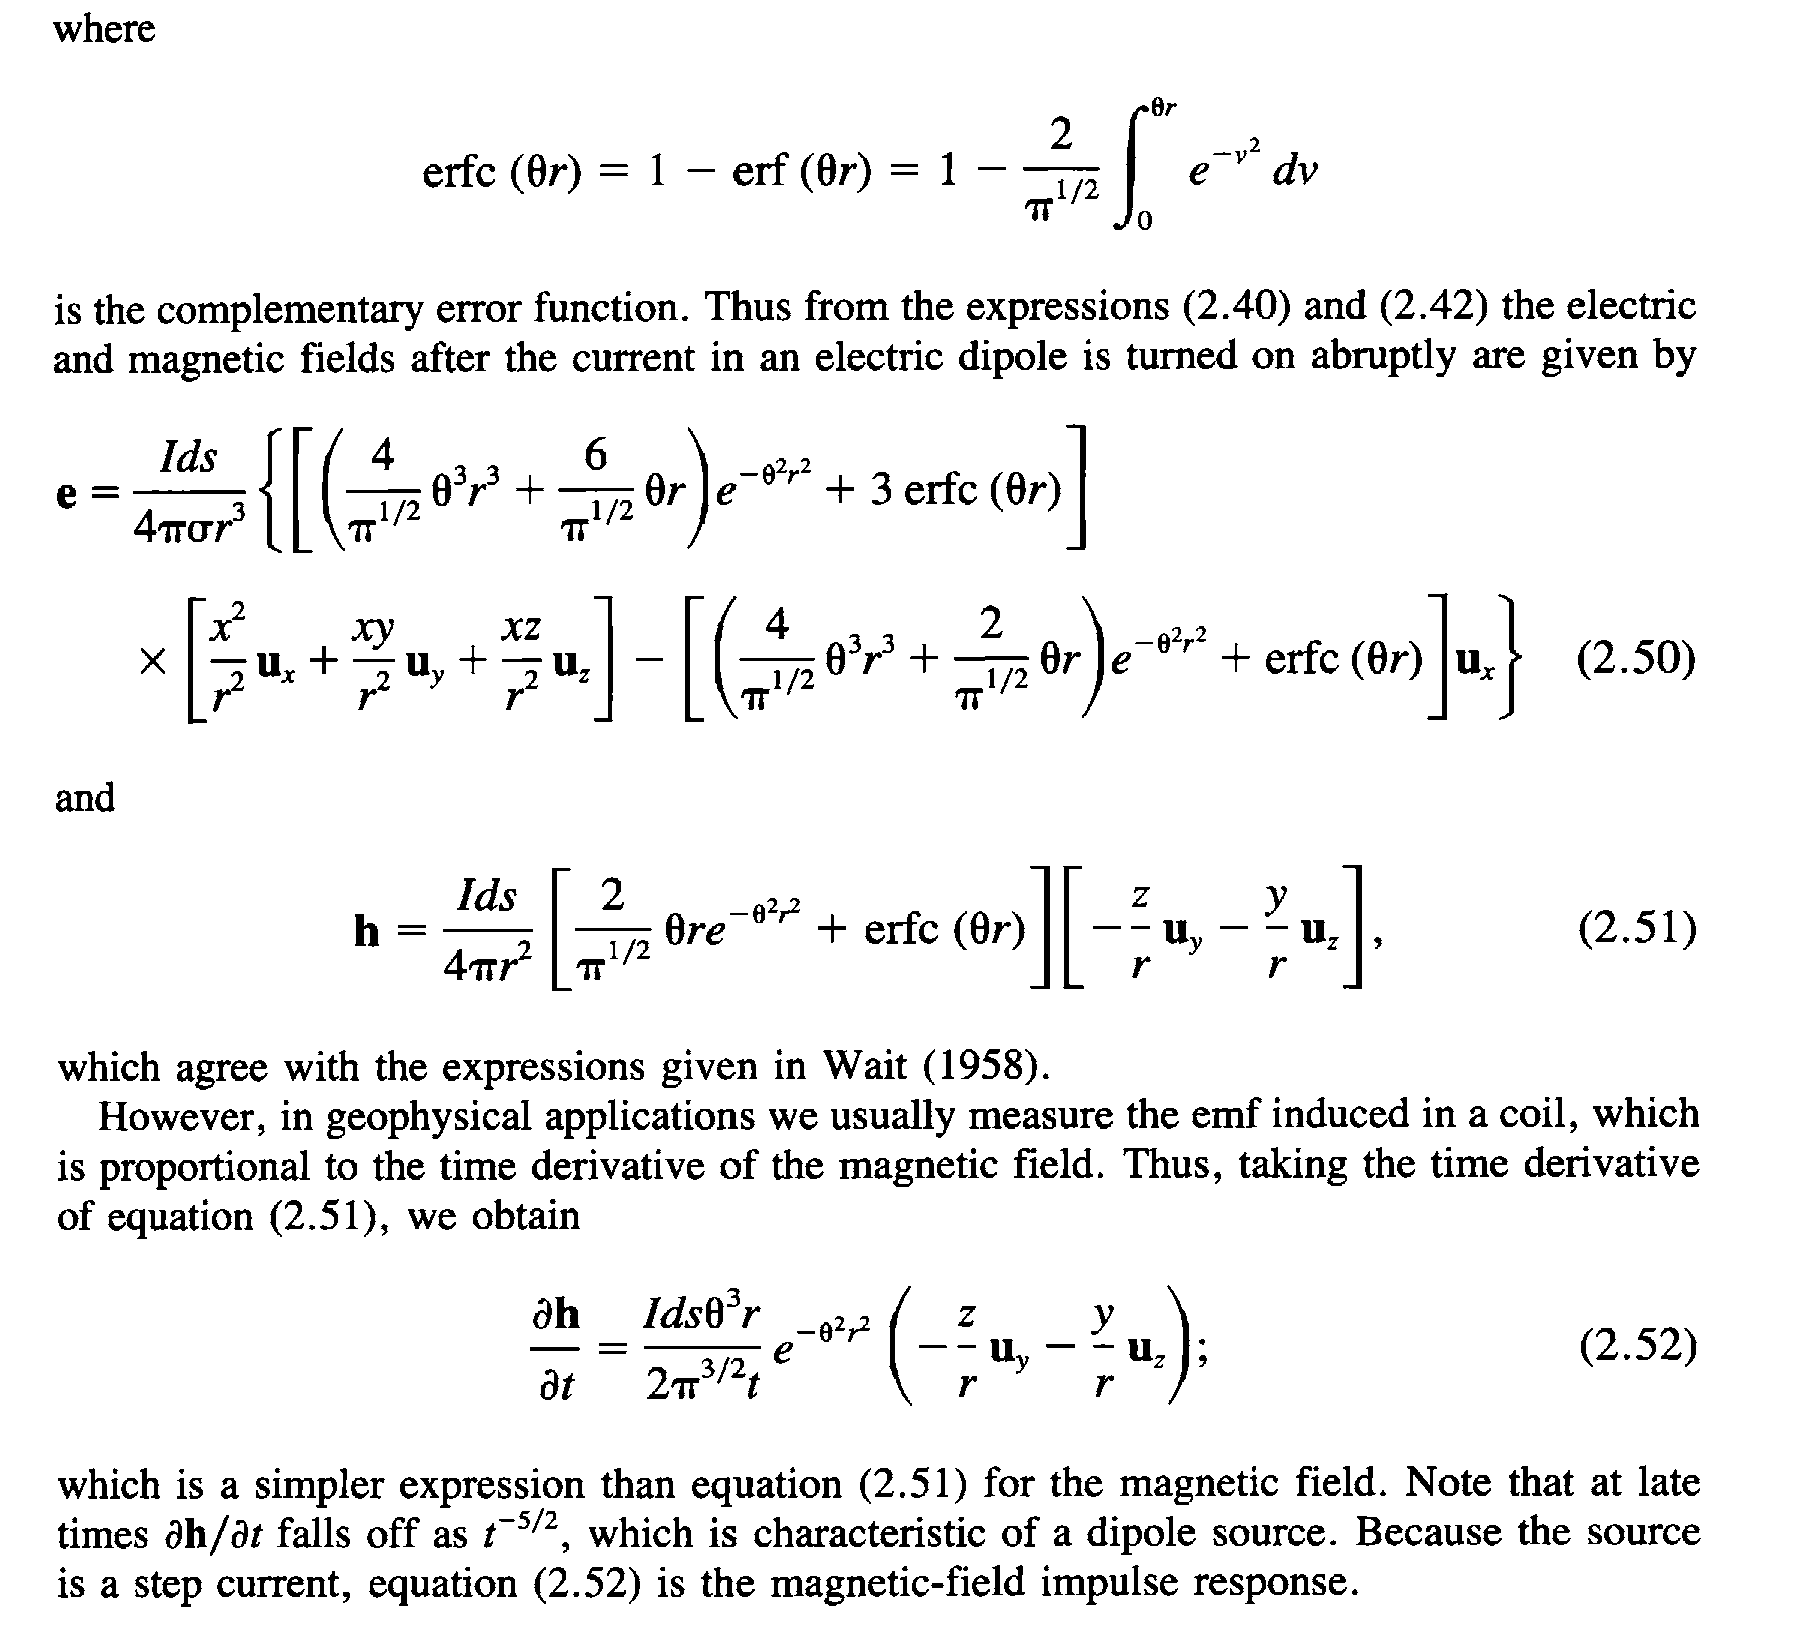

In [4]:
def tem_edp_whl(sigma,t,mu,rec):
    """
    # whole space, transient, E-dipole. 
    # E-dipole is in x direction
    """
    θ = np.sqrt((mu*sigma)/(4*t))
    r = np.linalg.norm(rec,2)

    h= np.zeros((np.shape(t)[0],3))
    hamp = 2/np.sqrt(np.pi)*θ*r*np.exp(-(r**2)*(θ**2)) + special.erfc(θ*r)
    hamp = 1-hamp
    hamp /= (4*np.pi*(r**2))
    h[:,1] = -rec[2]/r*hamp
    h[:,2] = -rec[1]/r*hamp
    
    dhdt= np.zeros((np.shape(t)[0],3))
    dhamp = (θ**3)*r/(2*t*np.pi**1.5)*np.exp(-(θ**2)*(r**2))
    dhdt[:,1] = -rec[2]/r*dhamp
    dhdt[:,2] = -rec[1]/r*dhamp
    return h,dhdt


In [6]:
res_air = 1e-14
res_sea = 1/3
depth = np.r_[0]
res = np.r_[res_air,res_sea]

Use 1.75 m as distance between receiver and dipole  
3.5m rectangular loop which is inspired by JOGMEC survey  
K.Nakayama(2019)  


In [7]:
src1 = np.r_[0. , 0. ,1000]
rec1 = np.r_[1.75 , 0., 1000]

In [8]:
t = np.logspace(-7,-2,51)


In [9]:

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': -1,
    'verb': 0,
    'ab': 62
}

empymod_b= -mu_0*empymod.dipole(**model_base)

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': 0,
    'verb': 0,
    'ab': 62
}

empymod_dbdt= -mu_0*empymod.dipole(**model_base)


In [10]:
location = np.r_[0.,0.,0.]
orientation = np.r_[1., 0., 0.]
current = 1.
sigma = 1/res_sea
sim = ElectricDipoleWholeSpace(
    time=t, location=location, orientation=orientation,
    current=current, sigma=sigma,mu=mu_0
)
xyz = ndgrid(np.r_[0.0], np.r_[-1.75], np.r_[0.0])
#xyz = ndgrid(np.linspace(-10, 10, 20), np.linspace(-10, 10, 20), np.array([0]))
geoana_b    = -sim.magnetic_flux_density(xyz)[:,2]
geoana_dbdt = -sim.magnetic_flux_density_time_deriv(xyz)[:,2]

In [15]:
rec2 = np.r_[0, -1.75, 0.]
sigma = 1/res_sea
hohmann_b_tmp, hohmann_dbdt_tmp = tem_edp_whl(sigma,t,mu_0, rec2)
hohmann_b = mu_0*hohmann_b_tmp[:,2]
hohmann_dbdt  = mu_0*hohmann_dbdt_tmp[:,2]

import results of original geoana data

In [18]:
time_org =  np.load('90_t.npy')
geoana_b_org =  np.load('90_geoana_b.npy')
geoana_dbdt_org =  np.load('90_geoana_dbdt.npy')

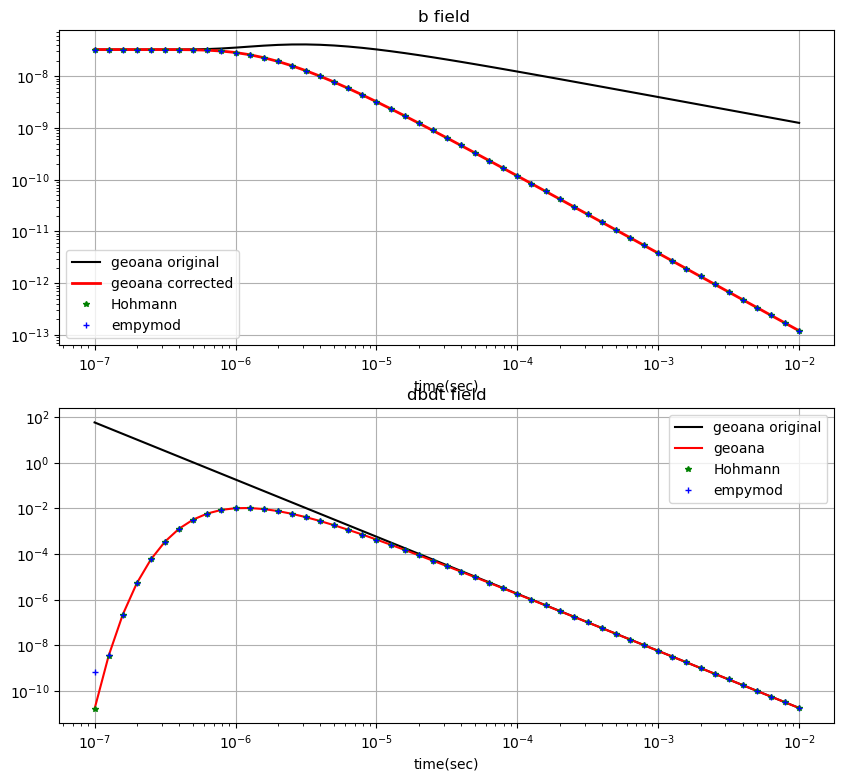

In [27]:
fig ,ax = plt.subplots(2,1,figsize=(10,9))
ax[0].loglog(time_org, geoana_b_org,"k-",label="geoana original")
ax[0].loglog(t, geoana_b,"r-",linewidth=2.,label="geoana corrected")
ax[0].loglog(t, hohmann_b,"g*",markersize=4.,label="Hohmann")
ax[0].loglog(t ,empymod_b,"b+",markersize=4.,label="empymod")
ax[0].set_title("b field ")
ax[1].loglog(time_org, geoana_dbdt_org,"k-",label="geoana original")
ax[1].loglog(t, geoana_dbdt,"r-",label="geoana")
#ax[1].loglog(t, -geoana_dbdt_rev,"r",markersize=2.,label="geoana corrected")
ax[1].loglog(t, hohmann_dbdt,"g*",markersize=4.,label="Hohmann")
ax[1].loglog(t, empymod_dbdt,"b+",markersize=4., label="empymod")
ax[1].set_title("dbdt field")

for a in ax :
    a.grid()
    a.legend()
    a.set_xlabel("time(sec)")


In [11]:
print(f'location {sim.location}')
print(f'orientation {sim.orientation}')
print(f'current {sim.current}')
print(f'length{sim.length}')
print(f'sigma{sim.sigma}')
print(f'mu{sim.mu}')
print(f'distance{sim.distance(xyz)}')
print(f'vector distance{sim.vector_distance(xyz)}')
#print(sim.diffusion_distance)
#print(sim.theta)


location [0. 0. 0.]
orientation [1. 0. 0.]
current 1.0
length1.0
sigma3.0
mu1.25663706212e-06
distance[1.75]
vector distance[[ 0.   -1.75  0.  ]]


In [12]:
dxyz = sim.vector_distance(xyz)
r = sim.distance(dxyz)

n_loc = len(r)
n_time = len(sim.time)

theta_r = np.outer(sim.theta, r)
tile_r = np.outer(np.ones(n_time), r)

term_1 = (
    sim.current * sim.length / (4 * np.pi * tile_r**2) * (
        -  2 / np.sqrt(np.pi) * theta_r * np.exp(-theta_r**2) + special.erf(theta_r)
    )
).reshape((n_time, n_loc, 1))
#r = sim repeat_scalar(r)
term_2 = (sim.cross_orientation(xyz) / r).reshape((1, n_loc, 3))

geoana_b_tst= - (np.tile(term_1, (1, 1, 3)) * np.tile(term_2, (n_time, 1, 1))).squeeze()


In [14]:
theta3_r = np.outer(sim.theta**3, r)
tile_t = np.outer(sim.time, np.ones(n_loc))

term_1 = (
sim.current * sim.length * theta3_r /
(2 * np.sqrt(np.pi)**3 * tile_t)  * 
np.exp(-theta_r**2)
).reshape((n_time, n_loc, 1))

#r = repeat_scalar(r)
term_2 = (sim.cross_orientation(xyz) / r).reshape((1, n_loc, 3))

geoana_dbdt_tmp= - (np.tile(term_1, (1, 1, 3)) * np.tile(term_2, (n_time, 1, 1))).squeeze()
